# Image in-painting
- guess pixel values in obscured/corrupted parts of image
- *total variation in-painting*:  choose pixel values $x_{i,j} \in \mathbf{R}^3$ to minimize
$$
\mbox{TV}(x) = \sum_{i,j} \left\| \left[ \begin{array}{c}
x_{i+1,j}-x_{i,j}\\
x_{i,j+1}-x_{i,j}
\end{array}\right]\right\|_2
$$
- a convex problem


# Example
- $512 \times 512$ color image
- denote corrupted pixels with $K \in \{0,1\}^{512 \times 512}$
    - $K_{ij} = 1$ if pixel value is known
    - $K_{ij} = 0$ if unknown

- $X_\mathrm{corr} \in \mathbf{R}^{512 \times 512 \times 3}$ is corrupted image
- 60 seconds to solve with CVXPY and SCS on a laptop

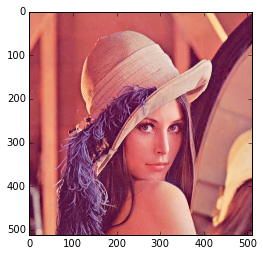

In [23]:
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib
import numpy as np
%matplotlib inline

image_file = cbook.get_sample_data('lena.png')

X_orig = plt.imread(image_file)
plt.imshow(X_orig)

In [24]:
from PIL import Image, ImageDraw, ImageFont
import itertools, textwrap
from itertools import cycle, islice

def drawText(image, fontsize, length):
    text = 'Lorem ipsum dolor sit amet, consectetuer adipiscing elit, \
sed diam nonummy nibh euismod tincidunt ut laoreet dolore magna \
aliquam erat volutpat. Ut wisi enim ad minim veniam, quis nostrud \
exerci tation ullamcorper suscipit lobortis nisl ut aliquip ex ea \
commodo consequat. Duis autem vel eum iriure dolor in hendrerit in \
vulputate velit esse molestie consequat, vel illum dolore eu feugiat \
nulla facilisis at vero eros et accumsan et iusto odio dignissim qui \
blandit praesent luptatum zzril delenit augue duis dolore te feugait \
nulla facilisi. Nam liber tempor cum soluta nobis eleifend option \
congue nihil imperdiet doming id quod mazim placerat facer possim'
    
    imshape = (image.shape[0], image.shape[1])
    dmg = Image.new("L",imshape)
    draw = ImageDraw.Draw(dmg)

    #fontsize = 80
    font = ImageFont.truetype("/Library/Fonts/Georgia.ttf", fontsize)
    text = "".join(islice(cycle(text),length))
    lines = textwrap.wrap(text, width = 40)
    w, h = dmg.size
    y_text = 0
    for line in lines:
        width, height = font.getsize(line)
        draw.text((0, y_text), line, font = font, fill = 255)
        y_text += height
    
    return (np.array(dmg) == 0).astype(int)

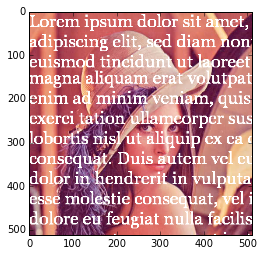

In [25]:
K = drawText(X_orig,40,600)
rows, cols, colors = X_orig.shape

X_corr = np.ones((rows,cols,colors))
X_corr[K==1,:] = X_orig[K==1,:]
plt.imshow(X_corr)

In [26]:
%%time
from cvxpy import *
variables = []
constr = []
for i in range(colors):
    X = Variable(rows, cols)
    variables += [X]
    constr += [mul_elemwise(K, X - X_corr[:, :, i]) == 0]

prob = Problem(Minimize(tv(*variables)), constr)
prob.solve(verbose=True, solver=SCS)

----------------------------------------------------------------------------
	SCS v1.1.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 4030762
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 1047553, constraints m = 2614279
Cones:	primal zero / dual free vars: 786432
	soc vars: 1827847, soc blks: 261121
Setup time: 9.39e+00s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 6.08e+00  5.68e+00  1.00e+00 -1.13e+06  1.61e+04  1.65e-10  7.55e-01 
   100| 2.48e-03  8.01e-04  3.48e-03  1.24e+04  1.25e+04  3.10e-11  2.17e+01 
   180| 8.58e-04  2.14e-04  8.47e-04  1.25e+04  1.25e+04  3.14e-11  4.00e+01 
------------------------

In [27]:
# the recovered image
X_rec = np.zeros((rows,cols,3))
for i,x in enumerate(variables):
    X_rec[:,:,i] = x.value

In [28]:
def showImgs(im1,im2,labels,filename=None):
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
    matplotlib.rcParams.update({'font.size': 14})
    fig.tight_layout()
    ax[0].imshow(im1)
    ax[1].imshow(im2)

    ax[0].axis('off')
    ax[1].axis('off')

    ax[0].set_title(labels[0])
    ax[1].set_title(labels[1])

    if filename:
        fig.savefig(filename, bbox_inches='tight')

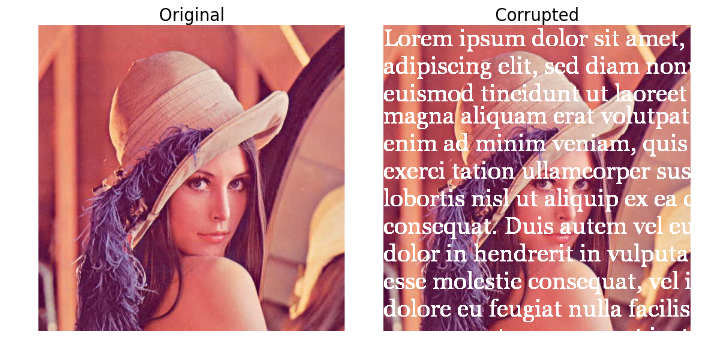

In [29]:
showImgs(X_orig,X_corr,['Original','Corrupted'],filename='inpaint_text1.pdf')

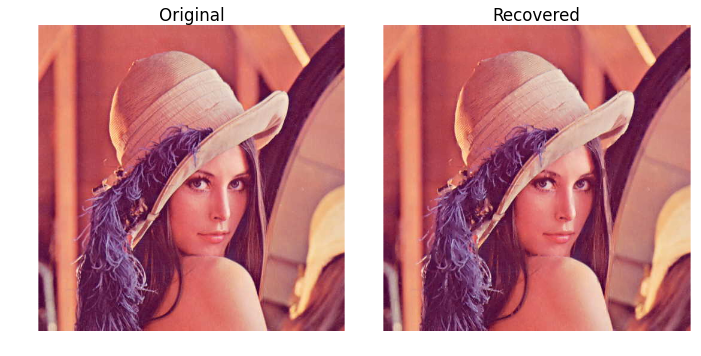

In [30]:
showImgs(X_orig,X_rec,['Original','Recovered'],filename='inpaint_text2.pdf')

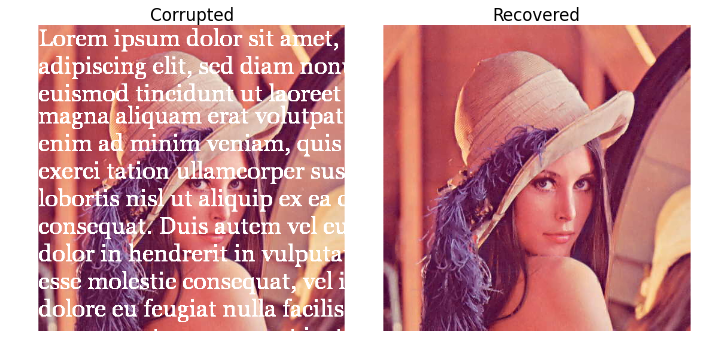

In [17]:
showImgs(X_corr,X_rec,['Corrupted','Recovered'],filename='inpaint_text_cr.pdf')

# Random pixels

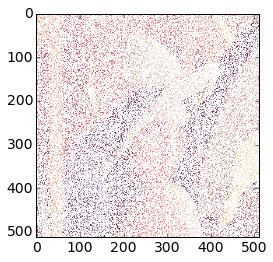

In [18]:
rows, cols, colors = X_orig.shape
K = (np.random.rand(rows,cols) < .2).astype(int)

X_corr = np.ones((rows,cols,colors))
X_corr[K==1,:] = X_orig[K==1,:]
plt.imshow(X_corr)

In [19]:
%%time
from cvxpy import *
variables = []
constr = []
for i in range(colors):
    X = Variable(rows, cols)
    variables += [X]
    constr += [mul_elemwise(K, X - X_corr[:, :, i]) == 0]

prob = Problem(Minimize(tv(*variables)), constr)
prob.solve(verbose=True, solver=SCS)

WARN: A->p (column pointers) not strictly increasing, column 262143 empty
WARN: A->p (column pointers) not strictly increasing, column 524287 empty
WARN: A->p (column pointers) not strictly increasing, column 786431 empty
----------------------------------------------------------------------------
	SCS v1.1.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 3553342
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 1047553, constraints m = 2614279
Cones:	primal zero / dual free vars: 786432
	soc vars: 1827847, soc blks: 261121
Setup time: 9.14e+00s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.48e+01  1.52e+01  1.00e+00

In [20]:
# the recovered image
X_rec = np.zeros((rows,cols,3))
for i,var in enumerate(variables):
    X_rec[:,:,i] = var.value

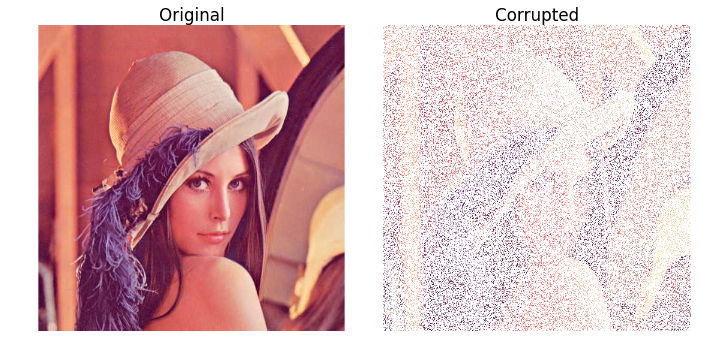

In [21]:
showImgs(X_orig,X_corr,['Original','Corrupted'],filename='inpaint80_1.pdf')

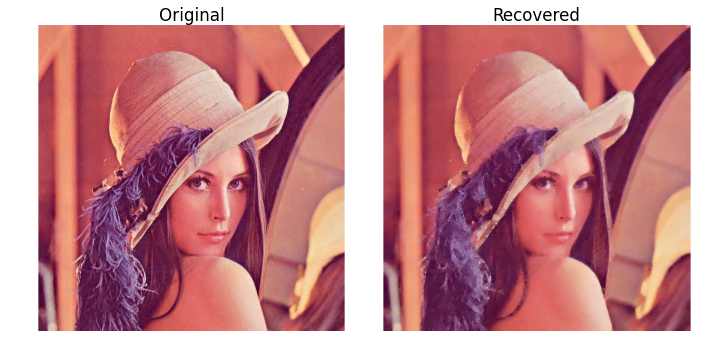

In [22]:
showImgs(X_orig,X_rec,['Original','Recovered'],filename='inpaint80_2.pdf')